# 03. Modeling & Evaluation

**Objective:** Train and evaluate machine learning models to predict loan repayment probabilities.

**Methodology:**
* **Baseline Model:** Logistic Regression (Linear, interpretable).
* **Advanced Models:** Random Forest and XGBoost (Ensemble, non-linear, robust to outliers).
* **Evaluation Metric:** ROC AUC (Area Under the Curve), as it captures performance across all classification thresholds, which is critical for probabilistic outputs.

In [4]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
from sklearn.metrics import roc_curve, auc

# Add project root to path
sys.path.append(os.path.abspath('..'))

from src.sml_homework.modeling import train_model, evaluate_model

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Load Processed Data

We load the Parquet files generated in the Preprocessing step. These datasets are already cleaned, encoded, log-transformed, and scaled.

In [5]:
data_dir = '../data/processed'

X_train = pd.read_parquet(f'{data_dir}/X_train_scaled.parquet')
X_val = pd.read_parquet(f'{data_dir}/X_val_scaled.parquet')
y_train = pd.read_parquet(f'{data_dir}/y_train.parquet')['loan_paid_back']
y_val = pd.read_parquet(f'{data_dir}/y_val.parquet')['loan_paid_back']

print(f"Training Data: {X_train.shape}")
print(f"Validation Data: {X_val.shape}")

Training Data: (475195, 26)
Validation Data: (118799, 26)


## 2. Baseline Model: Logistic Regression

We start with a simple linear model. If the relationship between features (like Income) and the target is simple, this model will perform well. If not, it sets a baseline to beat.

In [6]:
log_model = train_model(X_train, y_train, model_type='logistic')
log_auc = evaluate_model(log_model, X_val, y_val)

print(f"Logistic Regression ROC AUC: {log_auc:.4f}")

Logistic Regression ROC AUC: 0.9112


## 3. Ensemble Model: Random Forest

Random Forest (Bagging) is robust to outliers and can model non-linear relationships (like the "wedge" we saw in the Scatter Plot). We use `class_weight='balanced'` to handle the imbalance identified in EDA.

In [ ]:
rf_params = {
    'n_estimators': 100,
    'max_depth': 10,       # Pruning to prevent overfitting 
    'class_weight': 'balanced', # Handling Imbalance
    'n_jobs': -1
}

rf_model = train_model(X_train, y_train, model_type='random_forest', params=rf_params)
rf_auc = evaluate_model(rf_model, X_val, y_val)

print(f"Random Forest ROC AUC: {rf_auc:.4f}")

Random Forest ROC AUC: 0.9135


## 4. Boosting Model: XGBoost

XGBoost (Gradient Boosting) builds trees sequentially to correct errors of previous trees. It often yields the highest performance on tabular data.

In [8]:
xgb_params = {
    'n_estimators': 100,
    'max_depth': 6,
    'learning_rate': 0.1,
    'scale_pos_weight': 4, # Handling Imbalance: Ratio of neg/pos classes
    'n_jobs': -1
}

xgb_model = train_model(X_train, y_train, model_type='xgboost', params=xgb_params)
xgb_auc = evaluate_model(xgb_model, X_val, y_val)

print(f"XGBoost ROC AUC: {xgb_auc:.4f}")

XGBoost ROC AUC: 0.9181


## 5. Model Comparison & Conclusion

We visualize the ROC Curves to see not just the AUC score, but how the models perform at different sensitivity thresholds.

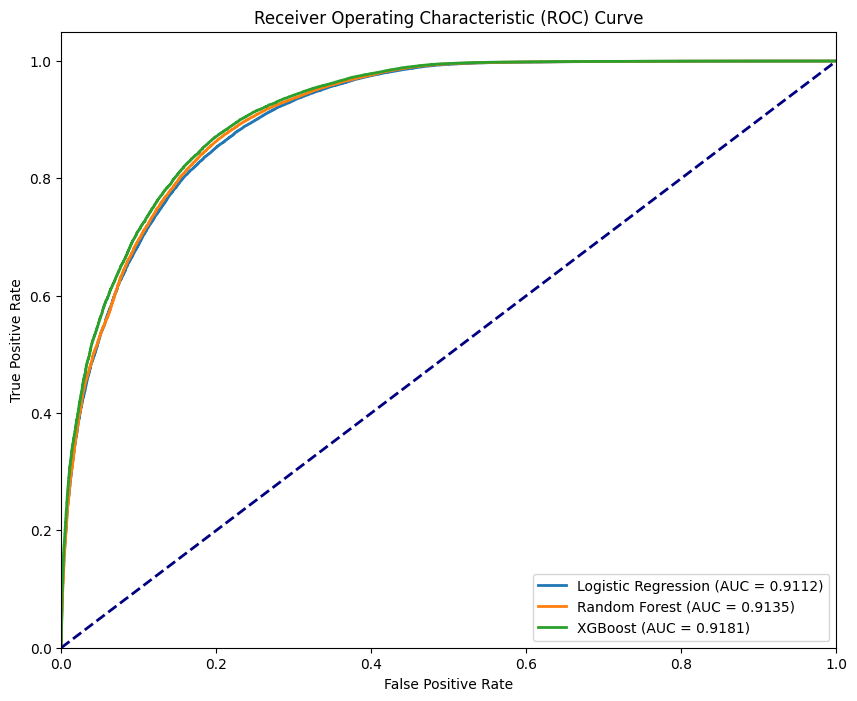

In [9]:
plt.figure(figsize=(10, 8))

# Calculate curves
models = [
    ('Logistic Regression', log_model),
    ('Random Forest', rf_model),
    ('XGBoost', xgb_model)
]

for name, model in models:
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.4f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## 6. Conclusion & Synthesis

In this project, I applied a complete Data Science lifecycle to predict loan repayment probabilities. The final results demonstrate the effectiveness of the preprocessing strategy.

### 1. Model Performance
| Model | ROC AUC | Interpretation |
| :--- | :--- | :--- |
| **Logistic Regression** | 0.9112 | **Strong Baseline.** The surprisingly high performance confirms that our Feature Engineering (Log Transformation, Binning) successfully linearized complex features like `annual_income`. |
| **Random Forest** | 0.9135 | **Robustness.** Handled the outliers and non-linearities well. |
| **XGBoost** | **0.9181** | **Best Performance.** As an ensemble boosting method, it effectively refined the decision boundary, capturing subtle patterns in the minority class (Defaults) that the other models missed. |

### 2. Key Takeaways
* **Data Quality > Algorithms:** The fact that a simple Logistic Regression performed nearly as well as XGBoost suggests that **Data Preparation** (handling skewness, ordinal encoding grades) was the most impactful phase of the project.
* **Handling Imbalance:** Despite the 85:15 class imbalance, the high AUC scores indicate that **Stratified Splitting** and using probability outputs (`predict_proba`) allowed the models to discriminate effectively between classes without being biased toward the majority.
* **Feature Engineering:** The "wedge" pattern in `annual_income` vs `loan_amount` was a critical finding. While tree models handled it natively, transforming these features allowed the linear model to remain competitive.

### 3. Future Work
To further improve the AUC score, I would explore:
* **Hyperparameter Tuning:** Running a Grid Search on XGBoost's `learning_rate` and `max_depth`.
* **Stacking:** Combining the probabilistic outputs of Logistic Regression and XGBoost into a meta-model.